In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score, precision_score, recall_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek
from ml.data_loader import load_and_prepare_data
pd.set_option('display.max_rows', None)

# Carregar base
df = load_and_prepare_data()
df.head()

,codigo_vaga,titulo_vaga,cliente,sap,nivel_profissional_exigido,nivel_academico_exigido,nivel_ingles_exigido,nivel_espanhol_exigido,competencias_tecnicas_exigidas,codigo_candidato,...,nivel_ingles,nivel_espanhol,outro_idioma,conhecimentos_tecnicos,cv_pt,target_contratado,keywords_exigidas,keywords_candidato,match_keywords,match_score
0,4530,CONSULTOR CONTROL M,"Morris, Moran and Dodson",Não,Pleno,Ensino Superior Completo,Nenhum,Nenhum,- Experiência comprovada em projetos de control-M,25632,...,,,-,,\ndados pessoais\nestado civil: casado\nidade:...,0,[],[],[],0
1,4530,CONSULTOR CONTROL M,"Morris, Moran and Dodson",Não,Pleno,Ensino Superior Completo,Nenhum,Nenhum,- Experiência comprovada em projetos de control-M,25529,...,Intermediário,Básico,-,,"solteiro, 47 anos\n\nestrada meringuava, nº 17...",0,[],[],[],0
2,4531,2021-2607395-PeopleSoft Application Engine-Dom...,Gonzalez and Sons,Não,Sênior,Ensino Médio Completo,Nenhum,Nenhum,O recurso Peoplesoft tem como responsabilidade...,25364,...,Avançado,Intermediário,-,"- PeopleSoft (PeopleTools 8.49, 8.53, 8.55, 8....",\n\nárea de atuação: lider de consultoria / ge...,1,[],[],[],0
3,4531,2021-2607395-PeopleSoft Application Engine-Dom...,Gonzalez and Sons,Não,Sênior,Ensino Médio Completo,Nenhum,Nenhum,O recurso Peoplesoft tem como responsabilidade...,25360,...,,,-,,informações pessoais\n estado civil: casado\n...,0,[],[],[],0
4,4533,2021-2605708-Microfocus Application Life Cycle...,Barnes-Woods,Não,Sênior,Ensino Médio Completo,Técnico,Fluente,Arquiteto\n\nFoco na área e automação.\n\nRequ...,26338,...,,,-,,"solteiro, brasileiro, 21/06/1987\nhabilitação ...",1,[],[],[],0


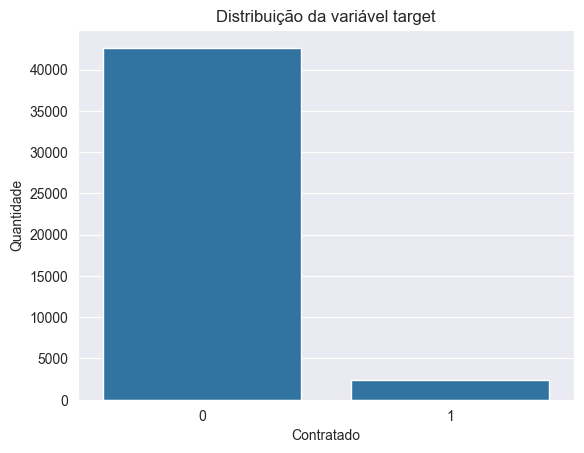

In [2]:
sns.countplot(data=df, x='target_contratado')
plt.title('Distribuição da variável target')
plt.xlabel('Contratado')
plt.ylabel('Quantidade')
plt.show()

In [3]:
df.describe(include='all')

,codigo_vaga,titulo_vaga,cliente,sap,nivel_profissional_exigido,nivel_academico_exigido,nivel_ingles_exigido,nivel_espanhol_exigido,competencias_tecnicas_exigidas,codigo_candidato,...,nivel_ingles,nivel_espanhol,outro_idioma,conhecimentos_tecnicos,cv_pt,target_contratado,keywords_exigidas,keywords_candidato,match_keywords,match_score
count,45071,45071,45071,45071,45071,45071,45071,45071,45071,45071,...,45071,45071,45071,45071,45071,45071.000000,45071,45071,45071,45071.0
unique,10522,9273,106,2,13,15,6,7,8838,23457,...,6,6,32,1902,21938,NaN,1,1,1,NaN
top,10567,SAP SD,Morrison Ltd,Não,Sênior,Ensino Superior Completo,Básico,Nenhum,.,833,...,,,-,,,NaN,[],[],[],NaN
freq,25,256,6549,43458,17987,33830,14913,22658,436,73,...,33667,33970,42434,39637,2552,NaN,45071,45071,45071,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.053826,NaN,NaN,NaN,0.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.225677,NaN,NaN,NaN,0.0
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.0
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.0
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.0
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.0


In [5]:
if 'sap' in df.columns:
    df['vaga_sap'] = df['sap'].map({'Sim': 1, 'Não': 0}).fillna(0)
    
    
from sentence_transformers import SentenceTransformer, util

model_emb = SentenceTransformer("all-MiniLM-L6-v2")

def safe_literal_eval(x):
    import ast
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return []
    return x

df['keywords_exigidas'] = df['keywords_exigidas'].apply(safe_literal_eval)
df['keywords_candidato'] = df['keywords_candidato'].apply(safe_literal_eval)

def calc_match_score_semantic(row):
    exigidas = row["keywords_exigidas"]
    candidato = row["keywords_candidato"]
    if not exigidas or not candidato:
        return 0.0
    emb_exigidas = model_emb.encode(exigidas, convert_to_tensor=True)
    emb_candidato = model_emb.encode(candidato, convert_to_tensor=True)
    sim_matrix = util.pytorch_cos_sim(emb_exigidas, emb_candidato)
    return float(sim_matrix.max(dim=1).values.mean())

df["semantic_match_score"] = df.apply(calc_match_score_semantic, axis=1)

/Users/viniciuspereira/Documents/FIAP/mlet_project5_v2/ai_rh_agent_llm-2/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
df["match_score"] = pd.to_numeric(df["match_score"], errors="coerce").fillna(0)
df["semantic_match_score"] = pd.to_numeric(df["semantic_match_score"], errors="coerce").fillna(0)
df["nivel_ingles"] = pd.to_numeric(df["nivel_ingles"], errors="coerce").fillna(0)
df["nivel_espanhol"] = pd.to_numeric(df["nivel_espanhol"], errors="coerce").fillna(0)
df["nivel_academico"] = pd.to_numeric(df["nivel_academico"], errors="coerce").fillna(0)
df["vaga_sap"] = pd.to_numeric(df["vaga_sap"], errors="coerce").fillna(0)

In [8]:
features = ['nivel_ingles', 'nivel_espanhol', 'nivel_academico', 'vaga_sap', 'semantic_match_score', 'match_score']
X = df[features]
y = df['target_contratado']

X_res, y_res = SMOTETomek().fit_resample(X, y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_res)

model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
model.fit(X_scaled, y_res)

/Users/viniciuspereira/Documents/FIAP/mlet_project5_v2/ai_rh_agent_llm-2/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/viniciuspereira/Documents/FIAP/mlet_project5_v2/ai_rh_agent_llm-2/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/viniciuspereira/Documents/FIAP/mlet_project5_v2/ai_rh_agent_llm-2/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validat

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

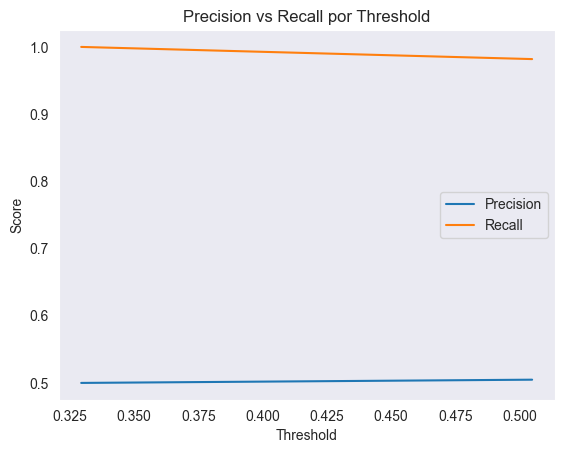

In [9]:
probas = model.predict_proba(X_scaled)[:, 1]
prec, rec, thresholds = precision_recall_curve(y_res, probas)

plt.plot(thresholds, prec[:-1], label='Precision')
plt.plot(thresholds, rec[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision vs Recall por Threshold')
plt.grid()
plt.legend()
plt.show()

In [10]:
y_pred = model.predict(X_scaled)
print(confusion_matrix(y_res, y_pred))
print(classification_report(y_res, y_pred))

[[ 1571 41074]
 [  772 41873]]
              precision    recall  f1-score   support

           0       0.67      0.04      0.07     42645
           1       0.50      0.98      0.67     42645

    accuracy                           0.51     85290
   macro avg       0.59      0.51      0.37     85290
weighted avg       0.59      0.51      0.37     85290



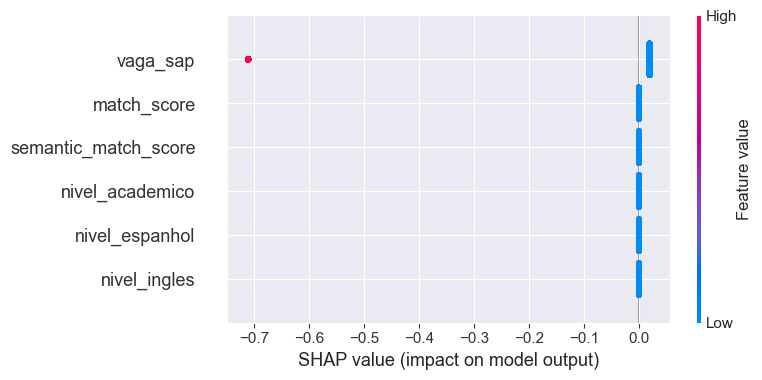

In [11]:
explainer = shap.Explainer(model)
shap_values = explainer(X_scaled)

shap.summary_plot(shap_values, features=X_res, feature_names=features)

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
lr = LogisticRegression(class_weight='balanced', max_iter=1000)

rf_score = cross_val_score(rf, X_scaled, y_res, cv=5, scoring="f1")
lr_score = cross_val_score(lr, X_scaled, y_res, cv=5, scoring="f1")

print("RandomForest F1:", rf_score.mean())
print("LogisticRegression F1:", lr_score.mean())

RandomForest F1: 0.535144273423504
LogisticRegression F1: 0.535144273423504
